## HW9 Solution

In this homework assignment, you will need to implement the Dyna-Q and Dyna-Q$^+$ algorithms in the Blocking Maze example (Page 34 of Lecture 9) and the Shortcut Maze example (Page 33 of Lecture 9).

* In the Blocking Maze example, obstacles will change after 1000 steps. You may set the step size $\alpha$ to 0.1, the number of planning steps $n$ to 10, and the weight of bonus reward $\kappa$ (Page 32 of Lecture 9) to $10^{-4}$. Please plot the cumulative rewards of Dyna-Q and Dyna-Q$^{+}$, up to 3000 time steps, aggregated over 20 independent runs (see e.g., Page 34 in Lecture 9). That is, you run 20 independent trials. For each trial, you run Dyna-Q and Dyan-Q$^+$ 3000 times steps, and average the cumulative reward over 20 trials.
* In the Shortcut Maze example, obstacles will switch after 3000 steps. You may set the step size $\alpha$ to 0.1, the number of planning steps $n$ to 50, and the weight of bonus reward $\kappa$ (Page 32 of Lecture 9) to $10^{-3}$. Please plot the cumulative rewards of Dyna-Q and Dyna-Q$^+$, up to 6000 time steps, aggregated over 5 independent runs (see e.g., Page 33 in Lecture 9).

In [2]:
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import heapq
from copy import deepcopy

The following code implements the standard maze and the Dyna-Q algorithm we discussed in the last seminar

<img src="graphs/maze.png" width=400>

The aim is to find a shortest path from S to G. Movements are allowed left, right, top and down but not on the greyed out obstacles.

In [3]:
class Maze:
    def __init__(self):
        # maze width
        self.WORLD_WIDTH = 9

        # maze height
        self.WORLD_HEIGHT = 6

        # all possible actions
        self.ACTION_UP = 0
        self.ACTION_DOWN = 1
        self.ACTION_LEFT = 2
        self.ACTION_RIGHT = 3
        self.actions = [self.ACTION_UP, self.ACTION_DOWN, self.ACTION_LEFT, self.ACTION_RIGHT]

        # start state
        self.START_STATE = [2, 0]

        # goal state
        self.GOAL_STATES = [[0, 8]]

        # all obstacles
        self.obstacles = [[1, 2], [2, 2], [3, 2], [0, 7], [1, 7], [2, 7], [4, 5]]
        self.old_obstacles = None
        self.new_obstacles = None

        # time to change obstacles
        self.obstacle_switch_time = None

        # initial state action pair values
        # self.stateActionValues = np.zeros((self.WORLD_HEIGHT, self.WORLD_WIDTH, len(self.actions)))

        # the size of q value
        self.q_size = (self.WORLD_HEIGHT, self.WORLD_WIDTH, len(self.actions))

        # max steps
        self.max_steps = float('inf')

    # take @action in @state
    # @return: [new state, reward]
    def step(self, state, action):
        x, y = state
        if action == self.ACTION_UP:
            x = max(x - 1, 0)
        elif action == self.ACTION_DOWN:
            x = min(x + 1, self.WORLD_HEIGHT - 1)
        elif action == self.ACTION_LEFT:
            y = max(y - 1, 0)
        elif action == self.ACTION_RIGHT:
            y = min(y + 1, self.WORLD_WIDTH - 1)
        if [x, y] in self.obstacles:
            x, y = state
        if [x, y] in self.GOAL_STATES:
            reward = 1.0
        else:
            reward = 0.0
        return [x, y], reward

In [4]:
# a wrapper class for parameters of dyna algorithms
class DynaParams:
    def __init__(self):
        # discount
        self.gamma = 0.95

        # probability for exploration
        self.epsilon = 0.1

        # step size
        self.alpha = 0.1

        # weight for elapsed time
        self.time_weight = 0

        # n-step planning
        self.planning_steps = 5

        # average over several independent runs
        self.runs = 10

        # threshold for priority queue
        self.theta = 0


# choose an action based on epsilon-greedy algorithm
def choose_action(method, state, q_value, tau_value, maze, dyna_params):
    if np.random.binomial(1, dyna_params.epsilon) == 1:
        return np.random.choice(maze.actions)
    else:
        if method == 'Dyna-Q':
            values = q_value[state[0], state[1], :]
        else:
            values = q_value[state[0], state[1], :] + dyna_params.time_weight*np.sqrt(tau_value[state[0], state[1], :])
        return np.random.choice([action for action, value in enumerate(values) if value == np.max(values)])

# Trivial model for planning in Dyna-Q
class TrivialModel:
    # @rand: an instance of np.random.RandomState for sampling
    def __init__(self, rand=np.random):
        self.model = dict()
        self.rand = rand

    # feed the model with previous experience
    def feed(self, state, action, next_state, reward):
        state = deepcopy(state)
        next_state = deepcopy(next_state)
        if tuple(state) not in self.model.keys():
            self.model[tuple(state)] = dict()
        self.model[tuple(state)][action] = [list(next_state), reward]

    # randomly sample from previous experience
    def sample(self):
        state_index = self.rand.choice(range(len(self.model.keys())))
        state = list(self.model)[state_index]
        action_index = self.rand.choice(range(len(self.model[state].keys())))
        action = list(self.model[state])[action_index]
        next_state, reward = self.model[state][action]
        state = deepcopy(state)
        next_state = deepcopy(next_state)
        return list(state), action, list(next_state), reward

In [5]:
# play for an episode for Dyna-Q algorithm
# @method: Dyna-Q or Dyna-Q+
# @q_value: state action pair values, will be updated
# @model: model instance for planning
# @maze: a maze instance containing all information about the environment
# @dyna_params: several params for the algorithm
def dyna_q(method, q_value, tau_value, model, maze, dyna_params):
    state = maze.START_STATE
    steps = 0
    while state not in maze.GOAL_STATES:
        # track the steps
        steps += 1

        # get action
        action = choose_action(method, state, q_value, tau_value, maze, dyna_params)

        # take action
        next_state, reward = maze.step(state, action)
        
        # tau-value update
        tau_value = tau_value + 1
        tau_value[state[0], state[1], action] = 0

        # Q-Learning update
        q_value[state[0], state[1], action] += \
            dyna_params.alpha * (reward + dyna_params.gamma * np.max(q_value[next_state[0], next_state[1], :]) -
                                 q_value[state[0], state[1], action])

        # feed the model with experience
        model.feed(state, action, next_state, reward)

        # sample experience from the model
        for t in range(0, dyna_params.planning_steps):
            state_, action_, next_state_, reward_ = model.sample()
            q_value[state_[0], state_[1], action_] += \
                dyna_params.alpha * (reward_ + dyna_params.gamma * np.max(q_value[next_state_[0], next_state_[1], :]) -
                                     q_value[state_[0], state_[1], action_])

        state = next_state

        # check whether it has exceeded the step limit
        if steps > maze.max_steps:
            break

    return steps


Next, let us consider the blocking maze example

### Blocking Maze

In the Blocking Maze environment the enrivonment changes after a number of iterations. This is a natural assumption as in many real world scenarios the environment does change with time, also measuring states can often not be done without an error, which can be related to changing environments.

Here, the model finds an optimal policy only for one of the tiles in the optimal policy to be blocked after the environment changes. Further exploration is needed to find the new optimal policy. While the Q-values of the optimal policy slowly decay, it is desirable to find the optimal policy faster.

This is exactly the benefit of Dyna-Q+, which favors exploration in the following way. When updating the Q-values based on previous experiences, a bonus is given to actions that haven't been used in many timesteps. The reward $r$ of an actions is increased by $\kappa \sqrt{\tau}$ where $\kappa$ is a small constant and $\tau$ the time that passed since the action in the current state was taken the last time.

<img src="graphs/blocking_maze.png">



In [6]:
# wrapper function for changing maze
# @maze: a maze instance
# @dynaParams: several parameters for dyna algorithms

methods = ['Dyna-Q', 'Dyna-Q+']

def changing_maze(maze, dyna_params):
    
    # set up max steps
    max_steps = maze.max_steps

    # track the cumulative rewards
    rewards = np.zeros((dyna_params.runs, 2, max_steps))

    for run in tqdm(range(dyna_params.runs)):
        # set up models
        model = TrivialModel() #, TimeModel(maze, time_weight=dyna_params.time_weight)]

        # initialize state action values
        q_values = [np.zeros(maze.q_size), np.zeros(maze.q_size)]
        # intialize tau values
        tau_values = np.zeros(maze.q_size)

        for i in range(len(methods)):

            # set old obstacles for the maze
            maze.obstacles = maze.old_obstacles

            steps = 0
            last_steps = steps
            while steps < max_steps:
                # play for an episode
                steps += dyna_q(methods[i], q_values[i], tau_values, model, maze, dyna_params)

                # update cumulative rewards
                rewards[run, i, last_steps: steps] = rewards[run, i, last_steps]
                rewards[run, i, min(steps, max_steps - 1)] = rewards[run, i, last_steps] + 1
                last_steps = steps

                if steps > maze.obstacle_switch_time:
                    # change the obstacles
                    maze.obstacles = maze.new_obstacles

    # averaging over runs
    rewards = rewards.mean(axis=0)

    return rewards


100%|███████████████████████████████████████████| 20/20 [00:48<00:00,  2.43s/it]


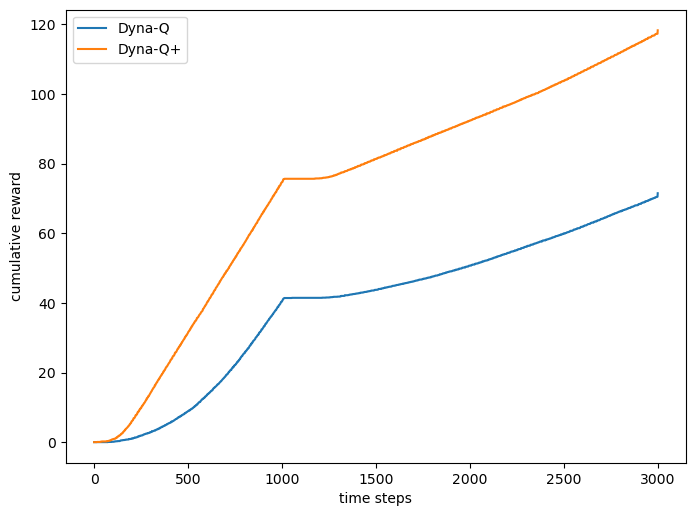

In [7]:
# set up a blocking maze instance
blocking_maze = Maze()
blocking_maze.START_STATE = [5, 3]
blocking_maze.GOAL_STATES = [[0, 8]]
blocking_maze.old_obstacles = [[3, i] for i in range(0, 8)]

# new obstalces will block the optimal path
blocking_maze.new_obstacles = [[3, i] for i in range(1, 9)]

# step limit
blocking_maze.max_steps = 3000

# obstacles will change after 1000 steps
# the exact step for changing will be different
# However given that 1000 steps is long enough for both algorithms to converge,
# the difference is guaranteed to be very small
blocking_maze.obstacle_switch_time = 1000

# set up parameters
dyna_params = DynaParams()
dyna_params.alpha = 1.0
dyna_params.planning_steps = 10
dyna_params.runs = 20

# kappa must be small, as the reward for getting the goal is only 1
dyna_params.time_weight = 1e-4

# play
rewards = changing_maze(blocking_maze, dyna_params)

plt.figure(figsize=(8, 6), dpi=100)

for i in range(len(methods)):
    plt.plot(rewards[i, :], label=methods[i])
    
plt.xlabel('time steps')
plt.ylabel('cumulative reward')
plt.legend()
plt.show()

### Shortcut Maze

In the Shortcut Maze we are in the opposite scenario to the Blocking Maze. After the environment changes a new shorter solutions does exist. The previously optimal policy is still valid and has the same reward as before, but is not optimal anymore.

Again, continued exploration is needed to find the new optimal policy.

<img src="graphs/shortcut_maze.png">

100%|█████████████████████████████████████████████| 5/5 [01:36<00:00, 19.31s/it]


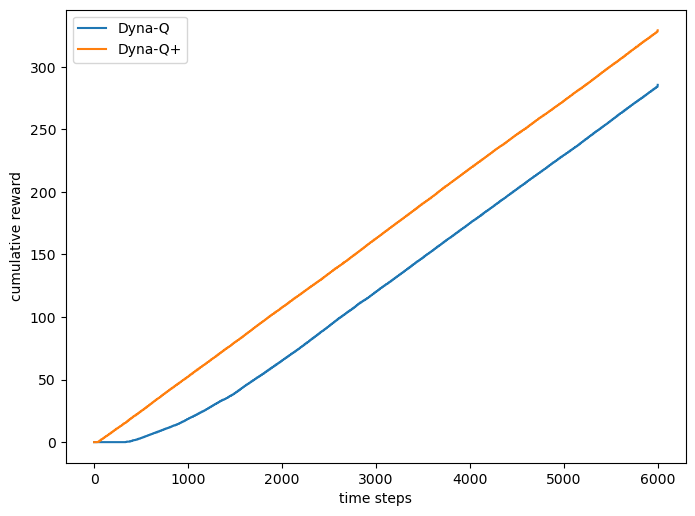

In [8]:
# set up a shortcut maze instance
shortcut_maze = Maze()
shortcut_maze.START_STATE = [5, 3]
shortcut_maze.GOAL_STATES = [[0, 8]]
shortcut_maze.old_obstacles = [[3, i] for i in range(1, 9)]

# new obstacles will have a shorter path
shortcut_maze.new_obstacles = [[3, i] for i in range(1, 8)]

# step limit
shortcut_maze.max_steps = 6000

# obstacles will change after 3000 steps
# the exact step for changing will be different
# However given that 3000 steps is long enough for both algorithms to converge,
# the difference is guaranteed to be very small
shortcut_maze.obstacle_switch_time = 3000

# set up parameters
dyna_params = DynaParams()

# 50-step planning
dyna_params.planning_steps = 50
dyna_params.runs = 5
dyna_params.time_weight = 1e-3
dyna_params.alpha = 1.0

# play
rewards = changing_maze(shortcut_maze, dyna_params)

plt.figure(figsize=(8, 6), dpi=100)

for i in range(len(methods)):
    plt.plot( rewards[i, :], label=methods[i])
plt.xlabel('time steps')
plt.ylabel('cumulative reward')
plt.legend()